In [1]:
import numpy as np
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Select the GPU index
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import math
from PIL import Image
from collections import OrderedDict
import torchvision.transforms as T
import matplotlib.pyplot as plt
import time
from torch.optim.lr_scheduler import _LRScheduler
import warnings
import spacy
from scipy.io import savemat
import dill as pickle
import thop
from torch_challenge_dataset import DeepVerseChallengeLoaderTaskTwo
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
#Parameters
onoffdict={'GPS': True, 'CAMERAS': True, 'RADAR': True}
lr=1e-3
num_epochs=100
reduction = 4
batch_size = 200
num_H = 64
weight_path=f'models0/CSINetplustask2/cr{reduction}/gps{onoffdict["GPS"]}_cam{onoffdict["CAMERAS"]}_rad{onoffdict["RADAR"]}/'

In [3]:
reduction

4

In [4]:
weight_path

'models0/CSINetplustask2/cr4/gpsTrue_camTrue_radTrue/'

In [5]:
if not os.path.exists(weight_path):
    os.makedirs(weight_path)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Analysis

In [7]:
train_dataset = DeepVerseChallengeLoaderTaskTwo(csv_path = r'./dataset_train.csv')
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=5)
test_dataset = DeepVerseChallengeLoaderTaskTwo(csv_path = r'./dataset_validation.csv')
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True, num_workers=5)

# Utils and Models

In [8]:
def CSI_reshape( y, csi_std=2.5e-06, target_std=1):
        ry = torch.real(y)
        iy= torch.imag(y)
        oy=torch.cat([ry,iy],dim=1)
        #scaling
        oy=(oy/csi_std)*target_std
        return oy

In [9]:
def CSI_ri_avg(y):
    ry=y[:,0,:,:]
    iy=y[:,1,:,:]
    y = torch.sqrt(ry**2+iy**2)
    return y

In [10]:
def cal_model_parameters(model):
    total_param  = []
    for p1 in model.parameters():
        total_param.append(int(p1.numel()))
    return sum(total_param)

In [11]:
def NMSE_cal(x_hat, x):
    x_real = torch.reshape(torch.real(x), (x.shape[0], -1))
    x_imag = torch.reshape(torch.imag(x), (x.shape[0], -1))
    x_hat_real = torch.reshape(torch.real(x_hat), (x.shape[0], -1))
    x_hat_imag = torch.reshape(torch.imag(x_hat), (x.shape[0], -1))
    power = torch.sum(x_real** 2 + x_imag** 2, dim=1)
    mse = torch.sum((x_real - x_hat_real) ** 2 + (x_imag - x_hat_imag) ** 2, dim=1)
    nmse = torch.mean(mse / power)
    return nmse

In [12]:
def normalize_image(image):
    # Convert image to float tensor
    image = image.float()
    # Normalize the image
    image /= 255.0
    # ImageNet mean values # ImageNet standard deviation values
    trans=T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) 
    image=trans(image)
    return image

In [13]:
def left_coordinates_batch(x_cor, y_cor):
    y_pix = torch.zeros_like(x_cor)
    x_pix = torch.zeros_like(y_cor)

    condition1 = y_cor < -4
    condition2 = (y_cor >= -4) & (y_cor < -1)
    condition3 = (y_cor >= -1) & (y_cor < 1)
    condition4 = (y_cor >= 1) & (y_cor < 4)
    condition5 = y_cor >= 4

    y_pix[condition1] = 100 + (250 - 100) * ((x_cor[condition1] - 80) / (125 - 80))
    y_pix[condition2] = 100 + (250 - 100) * ((x_cor[condition2] - 80) / (125 - 80))
    y_pix[condition3] = 100 + (250 - 100) * ((x_cor[condition3] - 80) / (125 - 80))
    y_pix[condition4] = 100 + (210 - 100) * ((x_cor[condition4] - 80) / (125 - 80))
    y_pix[condition5] = 100 + (190 - 100) * ((x_cor[condition5] - 80) / (125 - 80))

    x_pix[condition1] = (y_pix[condition1] - 30) / 1.35
    x_pix[condition2] = (y_pix[condition2] - 45) / 0.85
    x_pix[condition3] = (y_pix[condition3] - 55) / 0.70
    x_pix[condition4] = (y_pix[condition4] - 65) / 0.60
    x_pix[condition5] = (y_pix[condition5] - 65) / 0.5
    return x_pix, y_pix

In [14]:
def center_coordinates_batch(x_cor, y_cor):
    x_pix = torch.zeros_like(x_cor)
    y_pix = torch.zeros_like(y_cor)

    condition = y_cor < 0
    x_pix[condition] = 256 * ((x_cor[condition] - 119) / (139 - 119))
    x_pix[~condition] = 256 * ((x_cor[~condition] - 112) / (146 - 113))
    
    y_pix = 175 + (100 - 175) * ((y_cor - (-7)) / ((7) - (-7)))
    return x_pix, y_pix

In [15]:
def right_coordinates_batch(x_cor, y_cor):
    y_pix = torch.zeros_like(x_cor)
    x_pix = torch.zeros_like(y_cor)

    condition1 = y_cor < -4
    condition2 = (y_cor >= -4) & (y_cor < -1)
    condition3 = (y_cor >= -1) & (y_cor < 1)
    condition4 = (y_cor >= 1) & (y_cor < 4)
    condition5 = y_cor >= 4

    y_pix[condition1] = 250 + (100 - 250) * ((x_cor[condition1] - 125) / (200 - 125))
    y_pix[condition2] = 250 + (100 - 250) * ((x_cor[condition2] - 125) / (200 - 125))
    y_pix[condition3] = 250 + (100 - 250) * ((x_cor[condition3] - 125) / (200 - 125))
    y_pix[condition4] = 210 + (100 - 210) * ((x_cor[condition4] - 125) / (200 - 125))
    y_pix[condition5] = 190 + (100 - 190) * ((x_cor[condition5] - 125) / (200 - 125))

    x_pix[condition1] = -(y_pix[condition1] - 370) / 1.25
    x_pix[condition2] = -(y_pix[condition2] - 285) / 0.87
    x_pix[condition3] = -(y_pix[condition3] - 250) / 0.73
    x_pix[condition4] = -(y_pix[condition4] - 210) / 0.55
    x_pix[condition5] = -(y_pix[condition5] - 190) / 0.45
    return x_pix, y_pix

In [16]:
def center_image_batch(images, center_x, center_y, output_size, bounded=False):
    batch_size = images.size(0)
    
    if bounded == 'left':
        top = torch.clamp(center_y - output_size[0] // 2, 0, None)
        left = torch.clamp(center_x - output_size[1] // 2, 0, None)
    elif bounded == 'right':
        bottom = center_y + output_size[0] // 2
        right = torch.clamp(center_x + output_size[1] // 2, None, 250)
        top = torch.clamp(bottom - output_size[0], 0, None)
        left = right - output_size[1]
    else:
        top = center_y - output_size[0] // 2
        left = center_x - output_size[1] // 2

    resize_transform = transforms.Resize((output_size))
    cropped_images = [TF.crop(image, int(top[i].item()), int(left[i].item()), output_size[0], output_size[1]) 
                        for i, image in enumerate(images)]
    cropped_images = torch.stack([resize_transform(image) for image in cropped_images])
    return cropped_images

In [17]:
def process_imgs(gps, img_1, img_2, img_3, crop_size = (150,150)):
    x_cor = gps[:,0]
    y_cor = gps[:,1]

    x_pix,y_pix = left_coordinates_batch(x_cor, y_cor)
    img_1 = center_image_batch(img_1, x_pix.to(torch.int), y_pix.to(torch.int), crop_size, 'left')

    x_pix,y_pix = center_coordinates_batch(x_cor, y_cor)
    img_2 = center_image_batch(img_2, x_pix.to(torch.int), y_pix.to(torch.int), crop_size)

    x_pix,y_pix = right_coordinates_batch(x_cor, y_cor)
    img_3 = center_image_batch(img_3, x_pix.to(torch.int), y_pix.to(torch.int), crop_size, 'right')

    return img_1, img_2, img_3

Scheduler

In [18]:
class gpsdata(nn.Module):
    def __init__(self):
        super().__init__()
        self.gps_fc = nn.Linear(2, 16)
        self.gps_relu = nn.ReLU()

    def forward(self, gps):  
        gps = gps.to(torch.float32)

        x, y = gps[:,0], gps[:,1]
        x_normd = (x - torch.min(x)) / (torch.max(x) - torch.min(x))
        y_normd = (y - torch.min(y)) / (torch.max(y) - torch.min(y))
        gps_normd = torch.stack([x_normd,y_normd],dim=1)

        gps_out = self.gps_fc(gps_normd)  
        gps_out = self.gps_relu(gps_out)
        return gps_out

Radar Data Processing Layer

In [19]:
class radardata(nn.Module):
    
    def __init__(self):
        super(radardata, self).__init__()
        self.dropout = nn.Dropout(p=0.5)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=2, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 1, kernel_size=3, stride=2, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.lr1=nn.LeakyReLU(negative_slope=0.3, inplace=True)
        self.encoder_fc = nn.Linear(256,16)
                
    def forward(self, x):
        x=x.view(-1,1,512,128)
        x = (x - 5.1838e-06) / (28.0494 - 5.1838e-06)
        out = self.pool1(self.dropout(self.conv1(x)))
        out = self.pool2(self.dropout(self.conv2(out))).view(x.size(0), -1)
        out = self.dropout(self.encoder_fc(out))
        out = self.lr1(out)
        return out 

Camera Data Processing Layers

In [20]:
class cameradata(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=2, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 1, kernel_size=3, stride=2, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.lr1=nn.LeakyReLU(negative_slope=0.3, inplace=True)
        self.encoder = nn.Linear(1*81,16)
        self.dropout = nn.Dropout(0.5)

    def forward(self, cam):  
        cam = normalize_image(cam).to(torch.float32)
        out = self.pool1(self.dropout(self.conv1(cam)))
        out = self.pool2(self.dropout(self.conv2(out)))
        out = self.lr1(out).view(-1,1*81)
        out = self.dropout(self.encoder(out))
        return out

In [21]:
class ConvLayer(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size,stride=1, activation="LeakyReLu"):
        padding = (kernel_size - 1) // 2
        dict_activation ={"LeakyReLu":nn.LeakyReLU(negative_slope=0.3,inplace=True),"Sigmoid":nn.Sigmoid(),"Tanh":nn.Tanh()}
        activation_layer = dict_activation[activation]
        super(ConvLayer, self).__init__(OrderedDict([
            ("conv", nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding=padding, bias=False)),
            ("bn", nn.BatchNorm2d(out_planes)),
            ("activation",activation_layer)
        ]))

class RefineNetBlock(nn.Module):
    def __init__(self):
        super(RefineNetBlock, self).__init__()
        self.direct = nn.Sequential(OrderedDict([
            ("conv_7x7", ConvLayer(2, 8, 7, activation="LeakyReLu")),
            ("conv_5x5", ConvLayer(8, 16, 5, activation="LeakyReLu")),
            ("conv_3x3",ConvLayer(16,2,3,activation="Tanh"))
        ]))
        self.identity = nn.Identity()
        self.relu = nn.ReLU()
    def forward(self, x):
        identity = self.identity(x)
        out = self.direct(x)
        out = self.relu(out + identity)
        
        return out

In [22]:
onoffdictb={'GPS': False, 'CAMERAS': False, 'RADAR': False} #baseline dictionary
task1_weight_path=f'models/task1/gps{onoffdict["GPS"]}_cam{onoffdict["CAMERAS"]}_rad{onoffdict["RADAR"]}/'
weight_pathb=f'models0/CSINetplustask2/cr{reduction}/gps{onoffdictb["GPS"]}_cam{onoffdictb["CAMERAS"]}_rad{onoffdictb["RADAR"]}/'

In [23]:
class task2Encoder(nn.Module):
    
    def __init__(self, reduction=16):
        super(task2Encoder, self).__init__()
        total_size, in_channel, w, h = 8192, 2, 64, 64
        self.encoder_conv = nn.Sequential(OrderedDict([
            ("conv1_7x7", ConvLayer(2, 2, 7, activation='LeakyReLu')),
            ("conv2_7x7",ConvLayer(2,2,7,activation='LeakyReLu'))
        ]))
        self.encoder_fc = nn.Linear(total_size, total_size // reduction)
         
    
    def forward(self, x):
        n,c,h,w = x.detach().size()
        out = self.encoder_conv(x.to(torch.float32))
        out = self.encoder_fc(out.view(n, -1))
        return out
       

In [24]:
class task2Decoder(nn.Module):
    
    def __init__(self, reduction=16):
        super(task2Decoder, self).__init__()
        total_size, in_channel, w, h = 8192, 2, 64, 64
        self.decoder_fc = nn.Linear(total_size // reduction, total_size)
        self.decoder_conv = ConvLayer(2, 2, 7, activation="Sigmoid")
        self.decoder_refine = nn.Sequential(OrderedDict([
            (f"RefineNet{i+1}",RefineNetBlock()) for i in range(5)
        ]))
        self.decoder_sigmoid = nn.Sigmoid()
        
        
    def forward(self, Hencoded):
        bs = Hencoded.size(0)
        out = self.decoder_fc(Hencoded).view(bs, -1, 64, 64)
        out = self.decoder_conv(out)
        out = self.decoder_refine(out)
        
        return out

In [25]:
class task1decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.gp = gpsdata()
        self.rd = radardata()
        self.lc = cameradata()
        self.cc = cameradata()
        self.rc = cameradata()

        if int(num_H/2)*int(num_H/2) > 32:
            self.linear = nn.Linear(16*5, int(num_H/2)*int(num_H/2))
            self.output_fc = nn.Linear(int(num_H/2)*int(num_H/2), num_H*num_H)
            self.output_relu = nn.ReLU()
        else:
            self.linear = nn.Linear(16*5, 32)
            self.output_fc = nn.Linear(32, num_H*num_H)
            self.output_relu = nn.ReLU()
        
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self,gps,radar,left_cam,center_cam,right_cam,onoffdict):
        bs = gps.size(0)
        
        if onoffdict['GPS']:
             gps_out = self.gp(gps)
        else:
             gps_out = torch.zeros(bs, 16).to(device)
        
        if onoffdict['RADAR']:
            radar_out = self.rd(radar)
        else:
            radar_out = torch.zeros(bs, 16).to(device)
        
        if onoffdict['CAMERAS']:
            left_cam, center_cam, right_cam = process_imgs(gps, left_cam, center_cam, right_cam, crop_size = (150,150))
            lc_out = self.lc(left_cam)
            cc_out = self.cc(center_cam)
            rc_out = self.rc(right_cam)
        else:
            lc_out = torch.zeros(bs, 16).to(device)
            cc_out = torch.zeros(bs, 16).to(device)
            rc_out = torch.zeros(bs, 16).to(device)

        combined = torch.cat((gps_out, radar_out, lc_out, cc_out, rc_out), dim=1)
        
        output = self.linear(combined)
        output = self.output_relu(output)
        output = self.output_fc(output)
        output = self.output_relu(output)
        output = output.view(output.size(0), 1, num_H, num_H)

        return output

In [26]:
class Decoderwithmsi(nn.Module):
    def __init__(self, reduction):
        super().__init__()
        self.task1decoder = torch.load(task1_weight_path+"task1Decoder.pth")
        self.gp = self.task1decoder.gp
        self.rd = self.task1decoder.rd
        self.lc = self.task1decoder.lc
        self.cc = self.task1decoder.cc
        self.rc = self.task1decoder.rc
        self.bde = torch.load(weight_pathb+"task2Decoder.pth")
        self.allow_update = False  # Initially, do not allow weight updates
        #self.bde = baselinedecoder(reduction) 

        if int(num_H/2)*int(num_H/2) > 32:
            self.linear = self.task1decoder.linear
            self.output_fc1= nn.Linear(int(num_H/2)*int(num_H/2)+2*num_H*num_H, 2*num_H*num_H)
            self.output_fc2 = nn.Linear(2*num_H*num_H, 2*num_H*num_H)
            self.output_relu = nn.ReLU()
        else:
            self.linear = self.task1decoder.linear
            self.output_fc1 = nn.Linear(32+2*num_H*num_H, 2*num_H*num_H)
            self.output_fc2 = nn.Linear(2*num_H*num_H, 2*num_H*num_H)
            self.output_relu = nn.ReLU()
        
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, Hencoded,gps,radar,left_cam,center_cam,right_cam,onoffdict):
        bs = Hencoded.size(0)
        if self.allow_update:
            Hdecoded=self.bde(Hencoded)
            if onoffdict['GPS']:
                 gps_out = self.gp(gps)
            else:
                 gps_out = torch.zeros(bs, 16).to(device)

            if onoffdict['RADAR']:
                radar_out = self.rd(radar)
            else:
                radar_out = torch.zeros(bs, 16).to(device)

            if onoffdict['CAMERAS']:
                left_cam, center_cam, right_cam = process_imgs(gps, left_cam, center_cam, right_cam, crop_size = (150,150))
                lc_out = self.lc(left_cam)
                cc_out = self.cc(center_cam)
                rc_out = self.rc(right_cam)
            else:
                lc_out = torch.zeros(bs, 16).to(device)
                cc_out = torch.zeros(bs, 16).to(device)
                rc_out = torch.zeros(bs, 16).to(device)

            combined1 = torch.cat((gps_out, radar_out, lc_out, cc_out, rc_out), dim=1)

            output = self.linear(combined1)
        else:
            with torch.no_grad():
                Hdecoded=self.bde(Hencoded)
                if onoffdict['GPS']:
                     gps_out = self.gp(gps)
                else:
                     gps_out = torch.zeros(bs, 16).to(device)

                if onoffdict['RADAR']:
                    radar_out = self.rd(radar)
                else:
                    radar_out = torch.zeros(bs, 16).to(device)

                if onoffdict['CAMERAS']:
                    left_cam, center_cam, right_cam = process_imgs(gps, left_cam, center_cam, right_cam, crop_size = (150,150))
                    lc_out = self.lc(left_cam)
                    cc_out = self.cc(center_cam)
                    rc_out = self.rc(right_cam)
                else:
                    lc_out = torch.zeros(bs, 16).to(device)
                    cc_out = torch.zeros(bs, 16).to(device)
                    rc_out = torch.zeros(bs, 16).to(device)

                combined1 = torch.cat((gps_out, radar_out, lc_out, cc_out, rc_out), dim=1)

                output = self.linear(combined1)
                
        
        
        
        output = self.output_relu(output)
        combined2 = torch.cat((output, Hdecoded.view(bs,2*64*64)), dim=1)
        output = self.output_fc1(combined2)
        output = self.output_relu(output)
        output = self.output_fc2(output)
        output = output.view(bs, 2, num_H, num_H)

        return output

In [27]:
#complete task 2 model including encoder, decoder and channel
class task2model(nn.Module):
    def __init__(self, reduction=16):
        super().__init__()
        
        self.en=torch.load(weight_pathb+"task2Encoder.pth")
        self.allow_update = False  # Initially, do not allow weight updates
        
        self.de=Decoderwithmsi(reduction)
        
    
   
    def forward(self, Hin, gps, radar, left_cam, center_cam, right_cam, onoffdict): 
        
        #Encoder
        if self.allow_update:
            Hencoded=self.en(Hin)
        else:
            with torch.no_grad():
                Hencoded=self.en(Hin)
        
        
        
        
        #Decoder
        
        Hdecoded=self.de(Hencoded,gps,radar,left_cam,center_cam,right_cam,onoffdict)
        

        return Hdecoded

In [28]:
class WarmUpCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, T_max, T_warmup, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.T_warmup = T_warmup
        self.eta_min = eta_min
        super(WarmUpCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.T_warmup:
            return [base_lr * self.last_epoch / self.T_warmup for base_lr in self.base_lrs]
        else:
            k = 1 + math.cos(math.pi * (self.last_epoch - self.T_warmup) / (self.T_max - self.T_warmup))
            return [self.eta_min + (base_lr - self.eta_min) * k / 2 for base_lr in self.base_lrs]

In [29]:
model=task2model(reduction)
print(f'Number of parameters in Task2 Encoder: {cal_model_parameters(model.en)}')
print(f'Number of parameters in Task2 Decoder: {cal_model_parameters(model.de)}')

Number of parameters in Task2 Encoder: 16779664
Number of parameters in Task2 Decoder: 163720172


In [30]:
# Training

In [31]:
#Loss

#criterion=nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
criterion= nn.MSELoss().to(device)

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#if SGDR == True:
#    sched = CosineWithRestarts(optimizer, T_max=n_batches)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, threshold=0.00001, patience=200, verbose=True)

In [33]:
scheduler = WarmUpCosineAnnealingLR(optimizer=optimizer,
                                            T_max=num_epochs * len(train_loader),
                                            T_warmup=30 * len(train_loader),
                                            eta_min=1e-5)

In [34]:
model=model.to(device)

In [35]:
start_time = time.time()
num_train_batches=len(train_loader)
num_test_batches=len(test_loader)
train_losses = []
val_losses = []
patience_counter = 0
best_val_loss = float('inf')

for i in range(num_epochs):
    loss1 = 0
    nmse1 = 0
    epoch_time = time.time()
    model.train()
    if i >= 40: #update model weights after 100 epochs
        model.allow_update = True
        model.de.allow_update = True
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):  
        optimizer.zero_grad()
        y_train=y_train.to(device)
        # Apply the model
        Xin = CSI_reshape(X_train[0])
        y_pred=model(Xin.to(device),X_train[1].to(device),X_train[2].to(device),X_train[3].to(device),X_train[4].to(device),X_train[5].to(device), onoffdict = onoffdict)
        y_train_reshaped=CSI_reshape(y_train)
        loss = criterion(y_pred, y_train_reshaped) 
        # Update parameters
        loss.backward()
        optimizer.step()
        scheduler.step()
        loss1=loss1+loss
        
             
    train_loss=loss1/num_train_batches  
    
    train_losses.append(train_loss.item())
   
    # Run the testing batches
    model.eval()
    with torch.no_grad():
        loss1=0 
        nmse1=0
        for b, (X_test, y_test) in enumerate(test_loader):
            y_test=y_test.to(device)
            # Apply the model
            Xin = CSI_reshape(X_test[0])
            y_pred=model(Xin.to(device),X_test[1].to(device),X_test[2].to(device),X_test[3].to(device),X_test[4].to(device),X_test[5].to(device), onoffdict = onoffdict)
            y_test_reshaped=CSI_reshape(y_test)
            loss = criterion(y_pred, y_test_reshaped) 
            loss1=loss1+loss  
            
        val_loss=loss1/num_test_batches 
        
        val_losses.append(val_loss.item())
        
    print(f'epoch:{i+1}/{num_epochs} average reshaped TL:{train_loss.item():10.8f} average reshaped VL:{val_loss.item():10.8f} epoch time:{time.time() - epoch_time:.0f} seconds, lr:{optimizer.param_groups[0]["lr"]:.2e}')               
        # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, weight_path+"task2.pth")
        torch.save(model.en, weight_path+"task2Encoder.pth")
        torch.save(model.de, weight_path+"task2Decoder.pth")

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:1/100 average reshaped TL:1.26665509 average reshaped VL:1.06790566 epoch time:490 seconds, lr:3.33e-05
epoch:2/100 average reshaped TL:1.00555754 average reshaped VL:1.05046189 epoch time:498 seconds, lr:6.67e-05
epoch:3/100 average reshaped TL:0.99437100 average reshaped VL:1.07160854 epoch time:461 seconds, lr:1.00e-04
epoch:4/100 average reshaped TL:0.93464643 average reshaped VL:0.96336973 epoch time:444 seconds, lr:1.33e-04
epoch:5/100 average reshaped TL:0.86101204 average reshaped VL:0.90675944 epoch time:454 seconds, lr:1.67e-04
epoch:6/100 average reshaped TL:0.77888721 average reshaped VL:0.85876918 epoch time:463 seconds, lr:2.00e-04
epoch:7/100 average reshaped TL:0.68308103 average reshaped VL:0.81287473 epoch time:461 seconds, lr:2.33e-04
epoch:8/100 average reshaped TL:0.58716428 average reshaped VL:0.78096986 epoch time:460 seconds, lr:2.67e-04
epoch:9/100 average reshaped TL:0.50218910 average reshaped VL:0.75497466 epoch time:460 seconds, lr:3.00e-04
epoch:10/1

epoch:75/100 average reshaped TL:0.22075608 average reshaped VL:0.73094559 epoch time:502 seconds, lr:2.90e-04
epoch:76/100 average reshaped TL:0.21843342 average reshaped VL:0.74768233 epoch time:498 seconds, lr:2.70e-04
epoch:77/100 average reshaped TL:0.21670379 average reshaped VL:0.74583381 epoch time:509 seconds, lr:2.51e-04
epoch:78/100 average reshaped TL:0.21438684 average reshaped VL:0.72898734 epoch time:475 seconds, lr:2.32e-04
epoch:79/100 average reshaped TL:0.21302061 average reshaped VL:0.73193944 epoch time:517 seconds, lr:2.14e-04
epoch:80/100 average reshaped TL:0.21182090 average reshaped VL:0.75499320 epoch time:500 seconds, lr:1.96e-04
epoch:81/100 average reshaped TL:0.21011974 average reshaped VL:0.72961617 epoch time:489 seconds, lr:1.79e-04
epoch:82/100 average reshaped TL:0.20888712 average reshaped VL:0.73613495 epoch time:513 seconds, lr:1.63e-04
epoch:83/100 average reshaped TL:0.20783184 average reshaped VL:0.76916051 epoch time:515 seconds, lr:1.47e-04
e

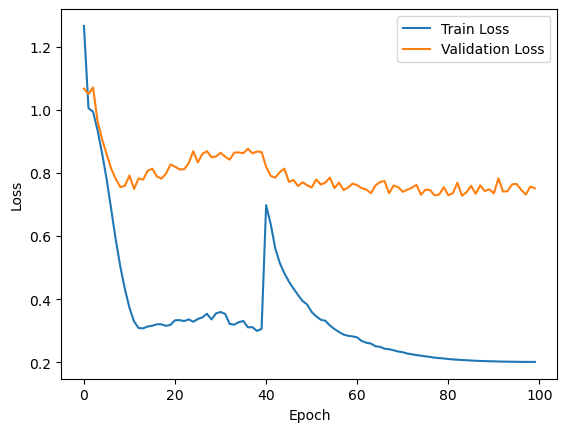

In [36]:
# Plotting
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
flops, params = thop.profile(model, inputs=(Xin.to(device),X_test[1].to(device),X_test[2].to(device),X_test[3].to(device),X_test[4].to(device),X_test[5].to(device), onoffdict), verbose=False)
print(f'Model Flops: {flops}')
print(f'Model Params Num: {params}\n')

Model Flops: 28377566800.0
Model Params Num: 176393260.0



In [38]:
np.save(weight_path+'train_loss.npy', train_losses)
np.save(weight_path+'val_loss.npy', val_losses)

# Inference

In [39]:
model2=torch.load(weight_path+"task2.pth").to(device)
# Run the testing batches
model2.eval()
with torch.no_grad():
    mse1=0
    for b, (X_test, y_test) in enumerate(test_loader):
        y_test=y_test.to(device)
        # Apply the model
        Xin = CSI_reshape(X_test[0])
        y_pred=model2(Xin.to(device),X_test[1].to(device),X_test[2].to(device),X_test[3].to(device),X_test[4].to(device),X_test[5].to(device), onoffdict = onoffdict)
        y_test_reshaped=CSI_reshape(y_test.to(device))
        mse0 = criterion(CSI_ri_avg(y_pred), CSI_ri_avg(y_test_reshaped)) 
        mse1+=mse0 
    avg_mse=mse1/num_test_batches

In [40]:
print(f'Average MSE:{avg_mse}')


Average MSE:0.88563472032547


In [41]:
h_list = torch.tensor([])
for b, (x,h) in enumerate(test_loader):
    h = CSI_ri_avg(CSI_reshape(h))
    h_list = torch.cat([h_list,h])
target_loss = torch.mean((torch.abs(h_list) - torch.mean(torch.abs(h_list))) ** 2)

In [42]:
improvement = (target_loss.item() - avg_mse) / target_loss.item() * 100
print(f'Percentage Improvement Achieved: {improvement:.4f}%')

Percentage Improvement Achieved: 37.2538%


In [43]:
target_loss

tensor(1.4115)